# Quantum Kernel Training algorithm

The structure of the quantum embedding circuit plays a decisive role in the QSVM algorithm.
Numerous quantum embedding kernel ansätze have been proposed. Testing all of them for a new dataset is unfeasible.
Therefore, following the method known in the classical kernel SVM as the kernel metrics learning or the kernel target alighnment, the quantum circuit structure could be trained to reproduce the properties of an *ideal* kernel constructed based on the properties of the training dataset.
For this, the encoding circuit is complemented with the variational part.
The variational parameters will be obtained as a result of the optimizational procedure to minimize a specially selected loss function.
This approach combines the ideas of the quantum kernel with the variational quantum circuit approaches.

[1] Lloyd, S.; Schuld, M.; Ijaz, A.; Izaac, J.; Killoran, N. Quantum Embeddings for Machine Learning. arXiv:2001.03622 (2020)

[2] Hubregtsen, T.; Wierichs, D.; Gil-Fuster, E.; Derks, P.-J. H. S.; Faehrmann, P. K.; Meyer, J. J. Training Quantum Embedding Kernels on Near-Term Quantum Computers. arXiv:2105.02276 (2021)

[3] (1) Glick, J. R.; Gujarati, T. P.; Corcoles, A. D.; Kim, Y.; Kandala, A.; Gambetta, J. M.; Temme, K. Covariant Quantum Kernels for Data with Group Structure. arxiv:2105.03406 (2021)

In [1]:
import numpy as np

from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, GridSearchCV
from sklearn.svm import SVC
from sklearn import metrics

from qksvm.QuantumFeatureMap import QuantumFeatureMap
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit.utils import QuantumInstance
from qiskit.providers.aer import AerSimulator
from qiskit.utils import algorithm_globals

from qksvm.LossFunctions import SVCLoss
from qksvm.QuantumKernelTraining import QKTKernel
from qksvm.QuantumKernelTraining import TerminationChecker
from qiskit.algorithms.optimizers import SPSA

from common import generate_moons_dataset
from common import visualize_decision_boundaries
from common import print_scores

seed = 12345

# Dataset

The [moons dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) is chosen for the demonstration purposes.
This dataset has non-trivial non-linear decision boundaries such that no separating hyperplane could be found to perfectly split 2 data classes.

Following the standard machine learning (ML) practice, we generate 2 independent datasets. The first dataset (`X_train=(x, y)` - the 2-d cartesian coordinates, and `y_train={0, 1}` - the datapoint labels) is used for training the chosen model and optimizing the model hyperparameters.
The second dataset `(X_test, y_test)` serves to crosscheck the accuracy of the model on previously unseen datapoints (the generalization performance).

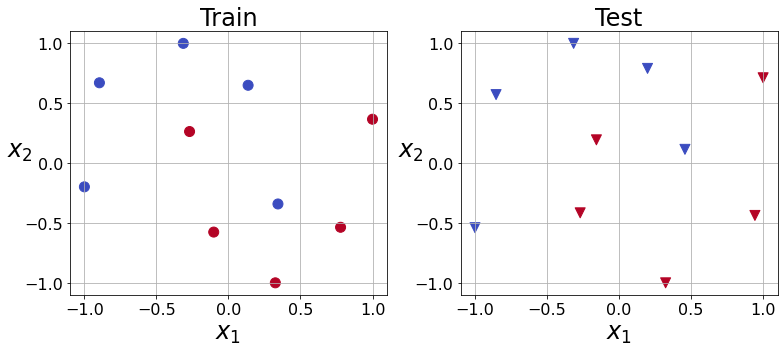

(10, 2)
(10, 2)


In [2]:
X_train, y_train, X_test, y_test = generate_moons_dataset()
print(X_train.shape)
print(X_test.shape)

# Quantum Kernel Training embedding variational ansatz

The quantum feature map generator considered earlier in the QKE tutorial can be used to generate the variational circuits.
The `QuantumFeatureMap` generator treats the gates given in the upper case as the encoding gates (i.e., the gates that depend parametrically on the input dataset points) and the gates given in the lower case as the variational gates.
The circuit generator also allows to include the scaling prefactor $\alpha$ into the list of the variational parameters. If `scale=True`, the $\theta[0]$ is set as a prefactor, otherwise the value of $\alpha$ should be provided by the user.
The total number of the variational parameters could be modified by increasing the number of qubits or the layers (circuit repeatitions) and checked based on the resulting quantum model scores.

In [3]:
n_features = len(X_train[0])
n_qubits = 2
n_layers = 2

fm = QuantumFeatureMap(
    num_features=n_features, 
    num_qubits=n_qubits,
    num_layers=n_layers,
    gates=['rx', 'cz', 'RY'],
    entanglement='linear',
    scale=True,
)
print(fm.draw(plot_barriers=False, fold=150))

     ┌──────────┐     ┌───────────────┐ ┌──────────┐     ┌───────────────┐ 
q_0: ┤ Rx(θ[1]) ├──■──┤ Ry(x[0]*θ[0]) ├─┤ Rx(θ[3]) ├──■──┤ Ry(x[0]*θ[0]) ├─
     ├──────────┤  │  ├───────────────┤ ├──────────┤  │  ├───────────────┤ 
q_1: ┤ Rx(θ[2]) ├──■──┤ Ry(x[1]*θ[0]) ├─┤ Rx(θ[4]) ├──■──┤ Ry(x[1]*θ[0]) ├─
     └──────────┘     └───────────────┘ └──────────┘     └───────────────┘ 


In [4]:
algorithm_globals.random_seed = seed
backend = QuantumInstance(
    AerSimulator(
        method='statevector',
        max_parallel_threads=8,
    ),
    seed_simulator=seed, seed_transpiler=seed,
)

To initialize the optimization procedure one should choose a loss function.
By setting `SVCLoss` as a loss function, the optimization algoritm will search for the parameters $\theta$ that maximize the margin between the positive and negative class training points embedding into the quantum Hilbert space.

The dependence of the loss function on the scaling parameter could be conveniently visualized. We can see a multi minima profile that suggests a special care about the choice of the optimization techniques.

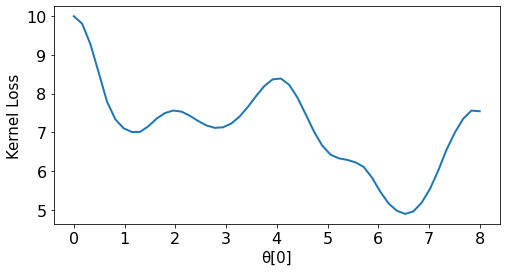

In [5]:
loss = SVCLoss(C=1)

np.random.seed(seed)
init_params = np.random.uniform(0, 2*np.pi, len(fm.train_params))

kernel = QuantumKernel(fm, user_parameters=fm.train_params, quantum_instance=backend)
loss.plot(kernel, X_train, y_train, init_params, grid=[0, 8, 50], show=True)

Qiskit provides implementations and wrappers for a majority of the [optimization algorithms](https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.html). Below we consider the widely used Simultaneous Perturbation Stochastic Approximation (SPSA) optimizer.

In [6]:
optimizer = SPSA(
    maxiter=200,
    learning_rate=None,
    perturbation=None,
    termination_checker=None,
    perturbation_dims=None,
)

By setting the loss function and the optimizer we are ready to compute the optimized quantum kernel and used it for training SVC.

SVCLoss optimal value:  3.311940185959676
Optimal parameters: [2.3493381  3.77906009 2.04837639 2.49859372 5.23309826]


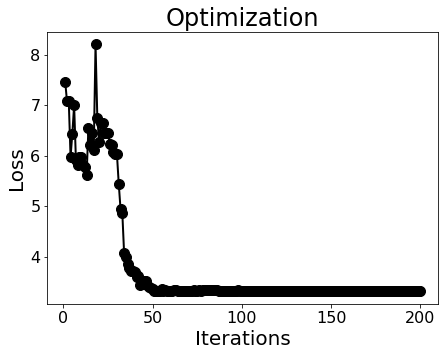


Prediction Scores:

		Train	Test
Accuracy:	1.00	1.00
 ROC_AUC:	1.00	1.00



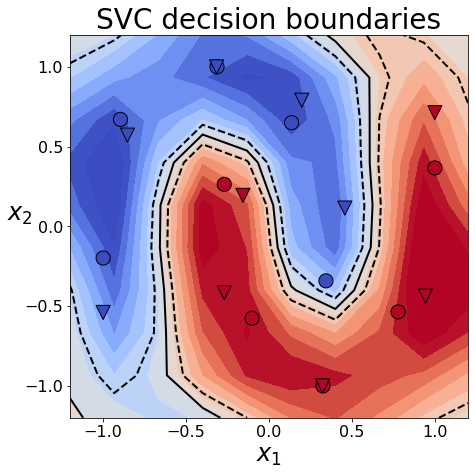

In [7]:
np.random.seed(seed)
init_params = np.random.uniform(0, 2*np.pi, len(fm.train_params))
init_params[0] = 1.0

qkt = QKTKernel(
    fm,
    X_train, y_train,
    init_params,
    loss=loss,
    optimizer=optimizer,
    backend=backend,
    seed=seed, 
    plot=True,
)

# Model training
clf = SVC(kernel=qkt.quantum_kernel.evaluate, random_state=seed)

clf.fit(X_train, y_train)
print_scores(clf, X_train, y_train, X_test, y_test)
visualize_decision_boundaries(clf, X_train, y_train, X_test, y_test)

We have found that for the chosen variational ansatz it took around 50 optimization iterations to obtain an quantum embedding ansatz that results to the maximum accuracy and (visually) correct decision boundaries.